In [1]:
from traffic.core import Traffic
from preprocessing import get_complete_flights, preprocess_traffic, generate_dummy_columns
import h5py
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import itertools

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  1


In [3]:
def seconds_till_arrival(flights_data: pd.DataFrame):
    time_till_arrival = flights_data["arrival_time"]- flights_data["timestamp"]
    seconds = time_till_arrival.dt.total_seconds()
    return seconds

In [4]:
def build_sequential(lr, input_dims, output_dims, layerSizes, activation, loss):
    model = keras.Sequential()
    model.add (keras.layers.Input(shape=input_dims))
    for size in layerSizes:
        model.add(keras.layers.Dense(size))
        model.add(keras.layers.LeakyReLU(alpha=0.05))

    model.add(keras.layers.Dense(output_dims,activation=activation))

    model.compile(optimizer=Adam(learning_rate=lr), loss=loss)

    return model

In [5]:
scaler = load('../trained_models/std_scaler_reg.bin')
file = "../data/Frankfurt_LH_2301.h5"

with h5py.File(file, 'r') as f:
    first = True
    for key in list(f.keys()):
        print(key)
        try:
            flights = Traffic.from_file(file, key=key,
                                    parse_dates=["day", "firstseen", "hour", "last_position",
                                                 "lastseen", "timestamp"])
        except:
            continue

        try:
            df_flights = preprocess_traffic(flights)
        except AttributeError:
            continue

        df = df_flights[
            ["distance", "altitude", "geoaltitude", "arrival_time", "timestamp", "vertical_rate",
             "groundspeed", "month", "weekday", "holiday"]].dropna()

        if not first:
            df_eval = pd.concat([df, df_eval])
        else:
            df_eval = df
            first = False


LH_230101
LH_230103
LH_230104
LH_230105
LH_230106
LH_230107
LH_230108
LH_230109
LH_230110
LH_230111
LH_230112
LH_230113
LH_230114
LH_230115
LH_230116
LH_230117
LH_230118
LH_230119
LH_230120
LH_230121
LH_230122
LH_230123
LH_230124
LH_230125
LH_230126
LH_230127
LH_230128
LH_230129
LH_230130
LH_230131


In [31]:
model_file = '../trained_models/model_with_cat_0429'
model = load_model(model_file)

In [7]:
df_train = generate_dummy_columns(df_eval)
df_train = df_train.sample(frac=1)

In [8]:
y = seconds_till_arrival(df_train)
X = df_train.drop(columns=["arrival_time", "timestamp", "month", "weekday"])
cols_numeric = ["distance", "altitude", "geoaltitude", "vertical_rate","groundspeed"]
X_numeric = X[cols_numeric]
X[cols_numeric] = scaler.transform(X_numeric)

In [30]:
model.evaluate(X,y)

165643/736944 [=====>........................] - ETA: 17:34 - loss: 386145.3750


KeyboardInterrupt



In [24]:
y_pred = model.predict(X.iloc[:100000,:])

3125/3125 [==============================] - 4s 1ms/step


In [25]:
err = abs(y[:100000] -y_pred[:,0])

In [28]:
err.max()/60

360.188671875

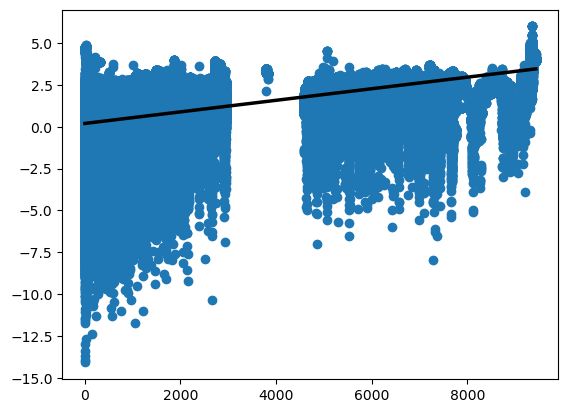

In [34]:
plt.scatter(df_eval["distance"],err)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5)

sadf